In [106]:
'''Here we testing the model's localization ability.

We consider multiple factors that could affect models' localization ability:
- The size of the object.
- The color of the object.
- The shape of the object.
- The background texture.
- The location of the object.
'''

from pydantic import BaseModel, Field
from PIL import Image, ImageDraw
import random
import math
import numpy as np

from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000

def calculate_color_delta(color1,color2):
    c1 = sRGBColor(color1[0],color1[1],color1[2])
    c2 = sRGBColor(color2[0],color2[1],color2[2])
    c1_lab = convert_color(c1,LabColor)
    c2_lab = convert_color(c2,LabColor)
    return delta_e_cie2000(c1_lab, c2_lab)

VALID_RESOLUTIONS = [
    # regular desktop resolution
    (1024, 768),
    (1280, 720),
    (1280, 800),
    (1920, 1080),
    (2560, 1440),
    (3840, 2160),
    (5120, 2880),
    (7680, 4320),
    # phone resolution
    (750, 1334),  # iPhone 6,7,8
    (828, 1792),  # iPhone XR
    (1080, 2256),  # vivo nex 3
    (1080, 2340),  # huawei p30
    (1080, 2376),  # vivo x50
    (1080, 2400),  # galaxy s20
    (1125, 2436),  # iPhone X, XS, 11 Pro
    (1170, 2532),  # iPhone 12, 12 Pro
    (1176, 2400),  # huawei mate30
    (1179, 2556),  # iphone 15
    (1200, 2670),  # xiaomi 15
    (1216, 2688),  # huawei mate 60
    (1228, 2700),  # huawei p60
    (1240, 2772),  # oppo find x6
    (1242, 2688),  # iPhone XS Max, 11 Pro Max
    (1260, 2800),  # vivo x90 pro
    (1284, 2778),  # iPhone 12 Pro Max
    (1290, 2796),  # iPhone 15 Pro Max
    (1344, 2992),  # google pixel 8 pro
    (1440, 3200),  # galaxy s20u
    (1440, 3088),  # galaxy note 20u
    (1440, 3168),  # oppo find x2
    (1440, 3168),  # oneplus 8 pro
    (1440, 3216),  # oneplus 11
]

COMMON_RESOLUTIONS = [
    (1280, 720),
    (828, 1792),  # iPhone XR
    (1920, 1080),
    (1080, 2400),  # galaxy s20
    (1179, 2556),  # iphone 15
    (1242, 2688),  # iPhone XS Max, 11 Pro Max
    (1440, 3216),  # oneplus 11
    (3840, 2160),
]


class Resolution(BaseModel):
    width: int
    height: int


class Position(BaseModel):
    x: int = Field(..., title='The x coordinate of the object.')
    y: int = Field(..., title='The y coordinate of the object.')


class BasicObject(BaseModel):
    color: str | tuple[int, int,
                       int] = Field(..., title='The color of the object.')
    bbox: list[int, int, int,
               int] = Field(..., title='The bounding box of the object.')
    shape: str = "Unknown"

    def draw(self, img: Image.Image, pos: Position):
        raise NotImplementedError

    def validate_point(self, pos: Position):
        raise NotImplementedError


class RectangleObject(BasicObject):
    shape: str = "Rectangle"
    width: int = Field(..., title='The width of the object.')
    height: int = Field(..., title='The height of the object.')

    def draw(self, img: Image.Image, pos: Position):
        draw = ImageDraw.Draw(img)
        x1, y1 = pos.x, pos.y
        x2, y2 = x1+self.width, y1+self.height
        draw.rectangle([x1, y1, x2, y2], fill=self.color)
        return img

    def validate_point(self, pos: Position):
        return 0 <= pos.x and pos.x <= self.bbox[2] and 0 <= pos.y and pos.y <= self.bbox[3]


class CircleObject(BasicObject):
    shape: str = "Circle"
    radius: int = Field(..., title='The radius of the object.')

    def draw(self, img: Image.Image, pos: Position):
        draw = ImageDraw.Draw(img)
        x1, y1 = pos.x, pos.y
        x2, y2 = x1+self.radius*2, y1+self.radius*2
        draw.ellipse([x1, y1, x2, y2], fill=self.color)
        return img

    def validate_point(self, pos: Position):
        # first calculate the distance between the pos to bbox center
        d = ((pos.x-self.bbox[2]/2)**2+(pos.y-self.bbox[3]/2)**2)**(0.5)
        if d <= self.radius:
            return True
        else:
            return False


class LocaliationTestItem(BaseModel):
    res: Resolution
    obj: BasicObject
    topleft_pos: Position
    background: str | tuple[int, int,
                            int] = Field(..., title='The background color of the image.')

    @property
    def center(self):
        return Position(x=self.topleft_pos.x+self.obj.bbox[2]//2, y=self.topleft_pos.y+self.obj.bbox[3]//2)

    def draw(self):
        back = Image.new(
            'RGB', (self.res.width, self.res.height), color=self.background)
        img = self.obj.draw(back, self.topleft_pos)
        return img

    def validate_point(self, pos: Position):
        delta_pos = Position(x=pos.x-self.topleft_pos.x,
                             y=pos.y-self.topleft_pos.y)
        return self.obj.validate_point(delta_pos)

    def validate_bbox(self, bbox: list[int, int, int, int], threshold: float = 0.5):
        """True if IoU is larger than threshold"""
        x1, y1 = self.topleft_pos.x, self.topleft_pos.y
        x2, y2 = x1+self.obj.bbox[2], y1+self.obj.bbox[3]
        x3, y3 = bbox[0], bbox[1]
        x4, y4 = bbox[0]+bbox[2], bbox[1]+bbox[3]
        # calculate the IoU
        x5 = max(x1, x3)
        y5 = max(y1, y3)
        x6 = min(x2, x4)
        y6 = min(y2, y4)
        inter_area = max(0, x6-x5)*max(0, y6-y5)
        union_area = (x2-x1)*(y2-y1) + (x4-x3)*(y4-y3) - inter_area
        return inter_area/union_area >= threshold


def build_full_localization_test(
        resolutions: list[tuple[int, int]] = COMMON_RESOLUTIONS,
        windows_ratio: list[float] = [0.1, 0.05, 0.01, 0.005],
        max_repeat_times: int = 1,
        delta_size=0.2
        ) -> dict[float, dict[tuple[int, int], list[LocaliationTestItem]]]:
    dataset = {}
    total_size = 0
    for ws in windows_ratio:
        for res in resolutions:
            if res not in dataset:
                dataset[res] = {}
            dataset[res][ws] = []
            width,height = res
            # calculate how many samples is sufficient for the ws
            windows_area = int(ws*width*height)
            minimum_square_len = math.ceil(math.sqrt(windows_area))

            # 计算接近min_samples的行数和列数
            cols = int(2*width/minimum_square_len*math.sqrt(max_repeat_times))
            rows = int(2*height/minimum_square_len*math.sqrt(max_repeat_times))
            
            # 生成网格点
            x = np.linspace(0, width, cols)
            y = np.linspace(0, height, rows)

            # 计算网格间距
            x_spacing = width / (cols - 1)
            y_spacing = height / (rows - 1)
            
            # 创建网格
            xv, yv = np.meshgrid(x, y)
            grid_points = np.column_stack([xv.ravel(), yv.ravel()])
            
            # 生成随机偏移
            shifts_x = (np.random.rand(*grid_points[:, 0].shape) - 0.5) * x_spacing
            shifts_y = (np.random.rand(*grid_points[:, 1].shape) - 0.5) * y_spacing
            
            # 应用偏移
            shifted_points = grid_points + np.column_stack([shifts_x, shifts_y])

            # 确保偏移后的点在边界内
            shifted_points[:, 0] = np.clip(shifted_points[:, 0], 0, width-1)
            shifted_points[:, 1] = np.clip(shifted_points[:, 1], 0, height-1)

            def sample_objects(random_color = False):
                objs_type = np.random.randint(2,size=len(shifted_points))
                objs_area = ws*(
                    1+np.random.uniform(
                        -delta_size,
                        delta_size,
                        len(shifted_points))
                        )*width*height
                if random_color:
                    color1 = np.random.randint(0,255,(len(shifted_points),3))
                    color2 = np.random.randint(0,255,(len(shifted_points),3))
                else:
                    color1 = []
                    color2 = []
                    for bright in np.random.randint(0,1,(len(shifted_points))):
                        if bright:
                            color1.append((255,255,255))
                            color2.append((0,0,0))
                        else:
                            color1.append((0,0,0))
                            color2.append((255,255,255))
                # print(len(objs_type),len(shifted_points),len(objs_area),len(color1),len(color2))

                for otype,point,area,c1,c2 in zip(objs_type,shifted_points,objs_area,color1,color2):
                    if otype == 0:
                        # rectangle
                        # center point must be the `point`
                        max_width = min(point[0]*2,2*(width-point[0]),area/4)
                        min_width = max(4,math.sqrt(0.2*area))
                        if min_width > max_width:
                            # print(min_width,max_width)
                            continue

                        # Calculate width and height with a more balanced approach
                        aspect_ratio = random.uniform(0.5, 2)  # Adjust the range as needed for balance
                        obj_width = int(math.sqrt(area / aspect_ratio))
                        obj_height = int(area / obj_width)

                        # Ensure width and height are within bounds
                        obj_width = max(int(min_width), min(int(max_width), obj_width))
                        obj_height = int(area / obj_width)
                        obj = RectangleObject(width=obj_width, height=obj_height, color=c1, bbox=[
                                            0, 0, obj_width, obj_height])

                    if otype == 1:
                        # circle
                        max_radius = int(min(point[0],(width-point[0]),point[1],(height-point[1])))

                        if max_radius<=0:
                            continue
                            
                        radius = min(int((area/math.pi)**0.5),max_radius)
                        obj = CircleObject(radius=radius, color=c1, bbox=[
                               0, 0, 2*radius, 2*radius])
                
                    # print(max(point[0]-obj.bbox[2]//2,0))
                    dataset[res][ws].append(LocaliationTestItem(
                        res=Resolution(width=width,height=height),
                        obj=obj,
                        topleft_pos=Position(
                            x=int(max(point[0]-obj.bbox[2]//2,0)),
                            y=int(max(point[1]-obj.bbox[3]//2,0))
                        ),
                        background=c2
                    ))



            # sample simple colors with black and white background
            sample_objects(random_color=False)
            sample_objects(random_color=True)

            print(f"Res: {res}, ws: {ws}, total: {len(dataset[res][ws])}")
            total_size += len(dataset[res][ws])
    # print("Total: ",total_size)
    return dataset



In [107]:
tester = LocalizationTester(max_repeat_times=1)

Res: (1280, 720), ws: 0.1, total: 49
Res: (828, 1792), ws: 0.1, total: 47
Res: (1920, 1080), ws: 0.1, total: 52
Res: (1080, 2400), ws: 0.1, total: 55
Res: (1179, 2556), ws: 0.1, total: 51
Res: (1242, 2688), ws: 0.1, total: 48
Res: (1440, 3216), ws: 0.1, total: 50
Res: (3840, 2160), ws: 0.1, total: 55
Res: (1280, 720), ws: 0.05, total: 115
Res: (828, 1792), ws: 0.05, total: 130
Res: (1920, 1080), ws: 0.05, total: 116
Res: (1080, 2400), ws: 0.05, total: 118
Res: (1179, 2556), ws: 0.05, total: 124
Res: (1242, 2688), ws: 0.05, total: 126
Res: (1440, 3216), ws: 0.05, total: 103
Res: (3840, 2160), ws: 0.05, total: 111
Res: (1280, 720), ws: 0.01, total: 734
Res: (828, 1792), ws: 0.01, total: 682
Res: (1920, 1080), ws: 0.01, total: 744
Res: (1080, 2400), ws: 0.01, total: 684
Res: (1179, 2556), ws: 0.01, total: 679
Res: (1242, 2688), ws: 0.01, total: 682
Res: (1440, 3216), ws: 0.01, total: 691
Res: (3840, 2160), ws: 0.01, total: 733
Res: (1280, 720), ws: 0.005, total: 1469
Res: (828, 1792), ws:

In [95]:
async def random_pointer(item:LocaliationTestItem):
    import random
    x = random.randint(0,item.res.width)
    y = random.randint(0,item.res.height)
    return Position(x=x,y=y)

In [96]:
statics = await tester.run(random_pointer)

{'Windows Ratio': 0.1, 'Resolution': (1280, 720), 'Discernible': False}
{'Windows Ratio': 0.05, 'Resolution': (1280, 720), 'Discernible': False}
{'Windows Ratio': 0.01, 'Resolution': (1280, 720), 'Discernible': False}
{'Windows Ratio': 0.005, 'Resolution': (1280, 720), 'Discernible': False}
{'Windows Ratio': 0.1, 'Resolution': (828, 1792), 'Discernible': False}
{'Windows Ratio': 0.05, 'Resolution': (828, 1792), 'Discernible': False}
{'Windows Ratio': 0.01, 'Resolution': (828, 1792), 'Discernible': False}
{'Windows Ratio': 0.005, 'Resolution': (828, 1792), 'Discernible': False}
{'Windows Ratio': 0.1, 'Resolution': (1920, 1080), 'Discernible': False}
{'Windows Ratio': 0.05, 'Resolution': (1920, 1080), 'Discernible': False}
{'Windows Ratio': 0.01, 'Resolution': (1920, 1080), 'Discernible': False}
{'Windows Ratio': 0.005, 'Resolution': (1920, 1080), 'Discernible': False}
{'Windows Ratio': 0.1, 'Resolution': (1080, 2400), 'Discernible': False}
{'Windows Ratio': 0.05, 'Resolution': (1080, 24

In [97]:
statics[0]["meta"]["Resolution"],len(tester)

((1280, 720), 18557)

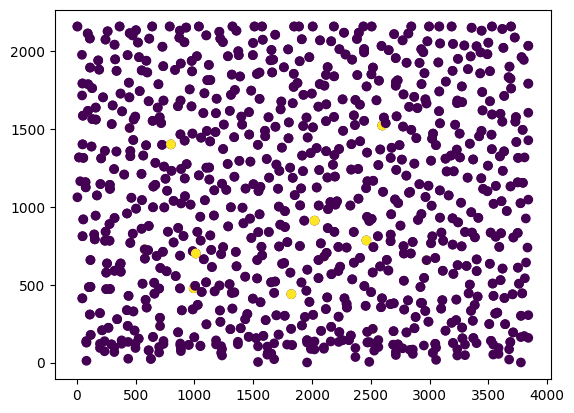

In [98]:
static = statics[-1]
x = []
y = []
for t,label in zip(static["results"]["test"],static["results"]["labels"]):
    t:LocaliationTestItem
    x.append(t.center.x)
    y.append(t.center.y)

x=  np.array(x)
y = np.array(y)
plt.figure()
plt.scatter(x,y,c=static["results"]["labels"])

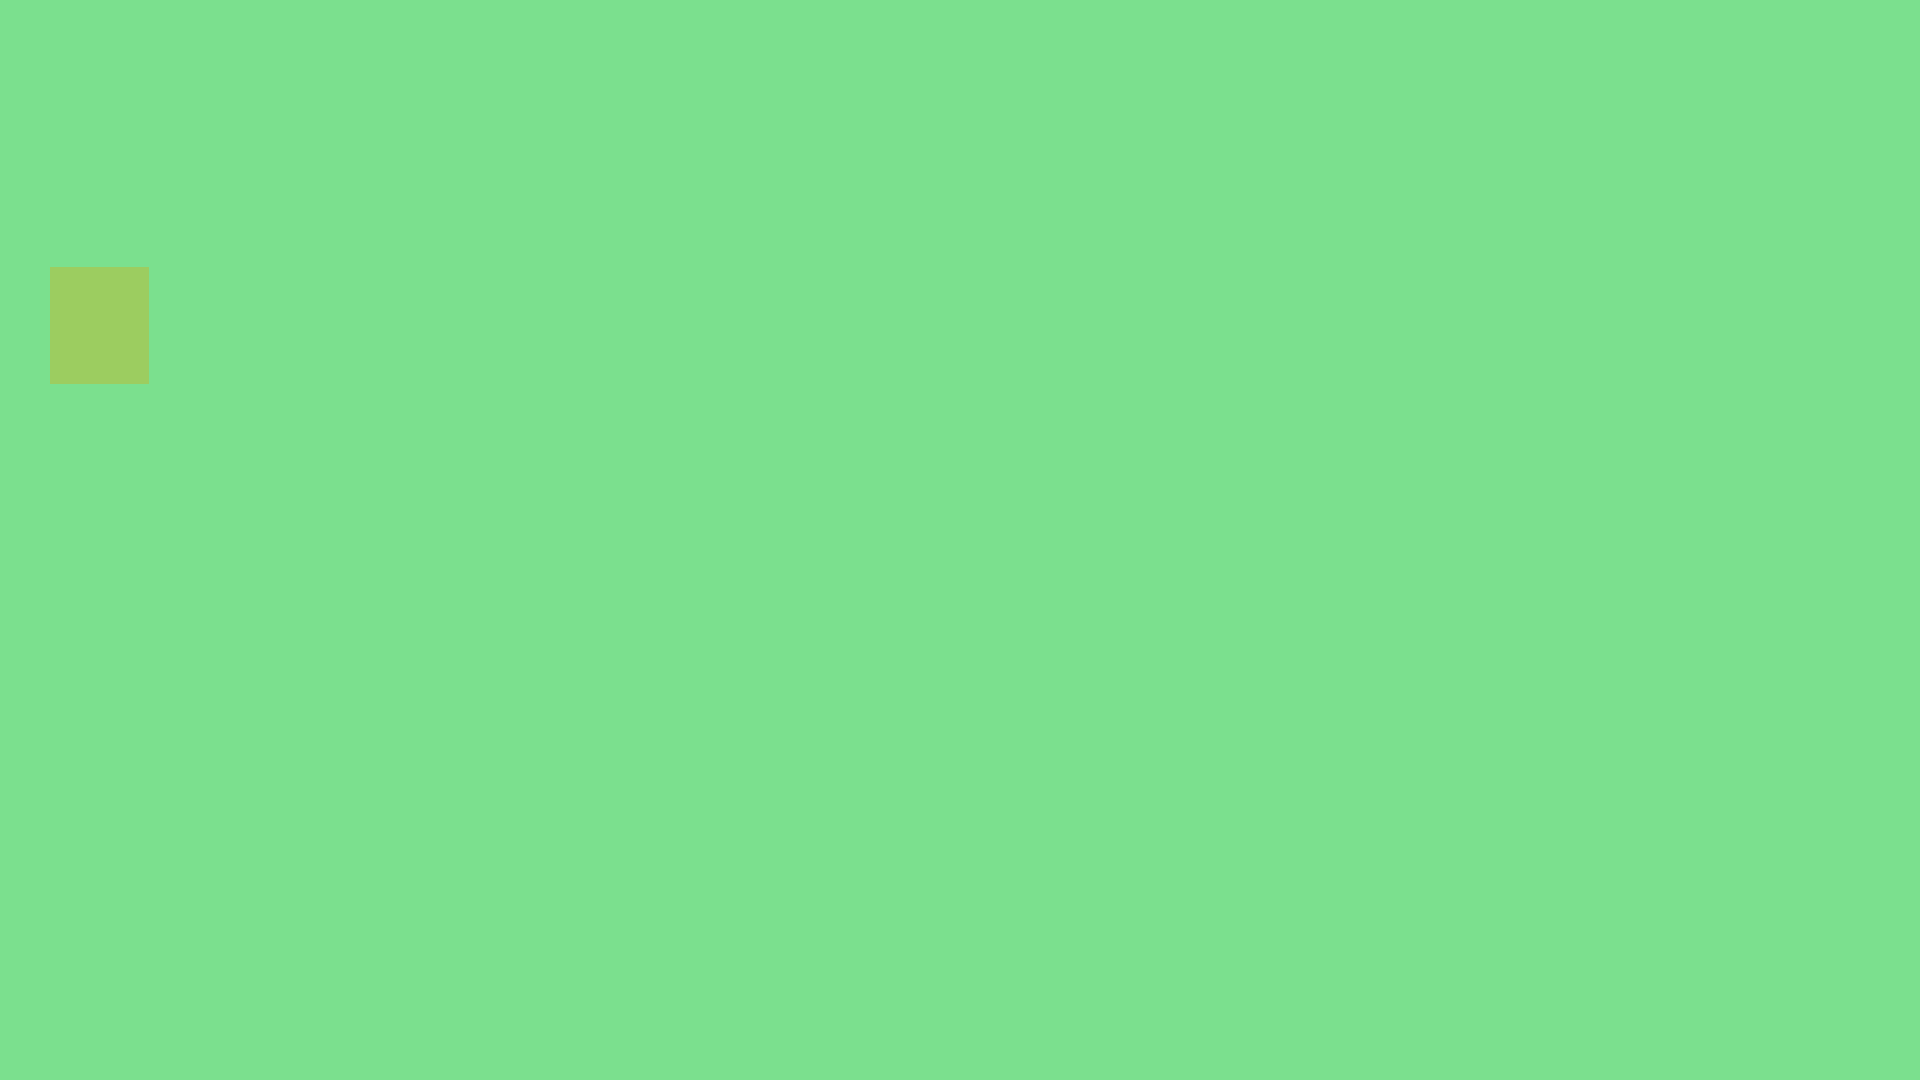

In [105]:
tester[random.randint(0,18004)].draw()

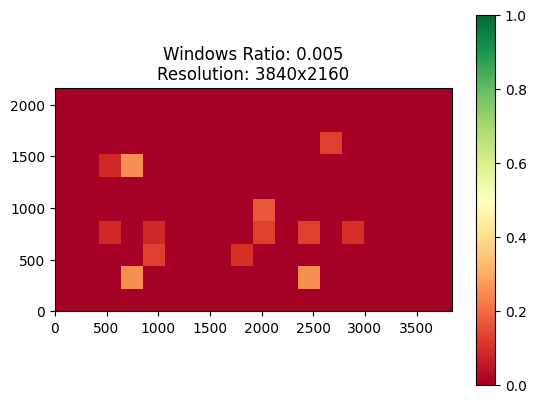

In [100]:
draw_res_correctness(statics[-1])

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not      R    G    B
0  1.0  0.0  0.0
1  0.0  1.0  0.0
2  0.0  0.0  1.0
3  0.0  0.0  1.0
4  1.0  1.0  0.0
5  0.0  1.0  1.0
6  1.0  0.0  1.0

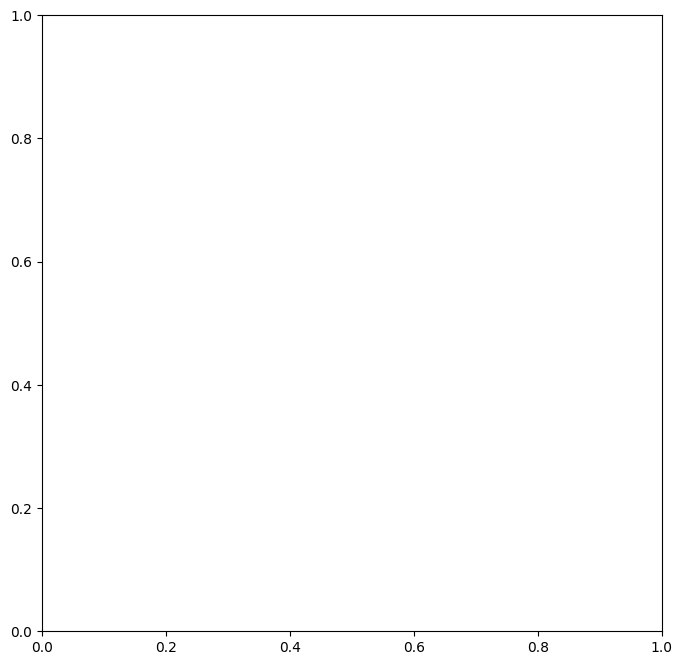

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from skimage import color
import numpy as np

# 示例数据：RGB颜色和True/False标签
data = {
    'R': [255, 0, 0, 0, 255, 0, 255],
    'G': [0, 255, 0, 0, 255, 255, 0],
    'B': [0, 0, 255, 255, 0, 255, 255],
    'Label': [True, False, True, False, True, False, True]
}

df = pd.DataFrame(data)

# 将RGB归一化到[0,1]范围
rgb_normalized = df[['R', 'G', 'B']].values / 255.0

# 转换为XYZ色彩空间
xyz = color.rgb2xyz(rgb_normalized.reshape(-1, 1, 3)).reshape(-1, 3)

# 转换为Lab色彩空间
lab = color.xyz2lab(xyz).reshape(-1, 3)

df['L'] = lab[:, 0]
df['a'] = lab[:, 1]
df['b'] = lab[:, 2]

# 绘制CIE Lab三角形
fig, ax = plt.subplots(figsize=(8, 8))

# 绘制所有颜色的点，颜色使用原始RGB
scatter = ax.scatter(df['a'], df['b'], 
                     c=df[['R', 'G', 'B']]/255.0, 
                     edgecolor='k', 
                     s=100, 
                     marker='o')

# 根据Label绘制不同的标记形状
for idx, row in df.iterrows():
    if row['Label']:
        ax.scatter(row['a'], row['b'], 
                   facecolors='none', 
                   edgecolors='k', 
                   s=200, 
                   marker='o', 
                   linewidths=2)

# 设置标签
ax.set_xlabel('a*')
ax.set_ylabel('b*')
ax.set_title('RGB Colors Visualized on CIE Lab Space with Labels')

# 添加网格
ax.grid(True, linestyle='--', alpha=0.5)

# 显示颜色空间的边界（可选）
# 可以通过绘制Convex Hull或者手动定义边界点来表示色彩空间的三角形
# 这里只是一个示例，不是严格的CIE Lab边界
boundary = np.array([
    [df['a'].min()-10, df['b'].min()-10],
    [df['a'].max()+10, df['b'].min()-10],
    [df['a'].max()+10, df['b'].max()+10],
    [df['a'].min()-10, df['b'].max()+10],
    [df['a'].min()-10, df['b'].min()-10]
])

ax.plot(boundary[:,0], boundary[:,1], 'k-', linestyle='-', linewidth=1)

plt.show()
